# Customisable Prediction Accuracy Plots

In this notebook, any specified model which adheres to the sklearn API can be fitted across customisable training windows, with predictions made and plotted for the specified test window. Models are persisted to disk for quickly repeatable runs.

In [17]:
import os
from joblib import dump, load
import numpy as np
import pandas as pd
from tscv import GapRollForward
from tqdm.notebook import tqdm

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# specify load and weather data details
DATA_PATH = '../data'
REGION = 'sa'
DATA_FILENAME = 'merged.csv'
OBS_PER_DAY = 24
X_EXCLUDE = ['datetime', 'net_load', 'total_load']
HOLIDAY_FILENAME = 'australian-public-holidays-combined-2021-2024.csv'

# for convenience below
obs = np.arange(1000) * OBS_PER_DAY

# specify methodology and model parameters
TRAIN_BEGIN = '2022-01-01'
TRAIN_MIN_SIZE = obs[365]   # change for expanding window
TRAIN_MAX_SIZE = obs[365]   # change for expanding window (np.inf)
TEST_MIN_SIZE = obs[2]
TEST_MAX_SIZE = obs[2]
TEST_FINAL_N = None         # set to None for rolling test window, or n to test final observations
ROLL_SIZE = obs[6]

# extract holidays from file
holiday_df = pd.read_csv(os.path.join(DATA_PATH, HOLIDAY_FILENAME), dtype='str')
holiday_df['Date'] = holiday_df['Date'].astype('datetime64[ns]')

# import and preprocess data
full_data_path = os.path.join(DATA_PATH, REGION, DATA_FILENAME)
df = pd.read_csv(os.path.relpath(full_data_path))
df['datetime'] = df['datetime'].astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['dow'] = dt.day_of_week
df['week'] = dt.isocalendar().week

holidays = holiday_df.loc[holiday_df['Jurisdiction'] == REGION, ['Date', 'Holiday Name']]
df['holiday'] = dt.date.isin(holidays['Date'].dt.date).astype('int')
#df['holiday'] = pd.merge(dt.floor('D'), holidays, left_on='datetime', right_on='Date', how='left')[
    #'Holiday Name'].replace(holidays['Holiday Name'].unique(), range(len(holidays['Holiday Name'].unique())))

df_subset = df[TRAIN_BEGIN <= df['datetime']]

# compute X and y column indices
X_cols = np.setdiff1d(df.columns.values, X_EXCLUDE)
X_inds = sorted(df.columns.get_indexer_for(X_cols))
y_ind = df.columns.get_loc('net_load')

X = df_subset.iloc[:, X_inds]
y = df_subset.iloc[:, y_ind]

# create train/test window strategy
tscv = GapRollForward(min_train_size=TRAIN_MIN_SIZE, max_train_size=TRAIN_MAX_SIZE,
                    min_test_size=TEST_MIN_SIZE, max_test_size=TEST_MAX_SIZE,
                    roll_size=ROLL_SIZE)
print(sum(1 for i in tscv.split(df_subset)), 'CV folds')

11 CV folds


GridSearchCV(cv=<generator object GapRollForward.split at 0x7faa4e552120>,
             estimator=HistGradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{}, {'l2_regularization': [0.1]},
                         {'interaction_cst': ['pairwise'],
                          'l2_regularization': [0.4]}],
             scoring='neg_mean_absolute_percentage_error')

In [ ]:

mdl = HistGradientBoostingRegressor()
params = [
    {},
    {'l2_regularization': [0.1]},
    {'l2_regularization': [0.4], 'interaction_cst': ['pairwise']},
]

search = GridSearchCV(mdl, param_grid=params, cv=tscv.split(df_subset), n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
search.fit(X, y)

In [18]:
results_df = pd.DataFrame(search.cv_results_)
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
0,{},2,-0.120570,0.043118
1,{'l2_regularization': 0.1},1,-0.117631,0.044480
2,"{'interaction_cst': 'pairwise', 'l2_regulariza...",3,-0.164932,0.058117


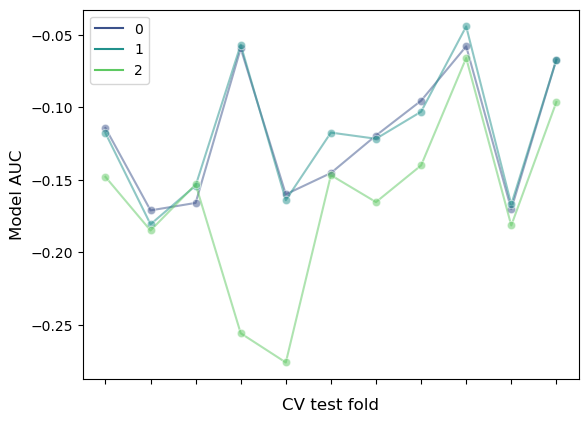

Correlation of models:
           0         1         2
0  1.000000  0.971707  0.372517
1  0.971707  1.000000  0.435169
2  0.372517  0.435169  1.000000


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="viridis",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")